In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  

# Big Question
Target Value = Residual Load
What values will we get real time?

# Data Transformation

### Reading and Clean the Dataset

In [6]:
# Load dataset and convert 'Date' column to datetime format
df = pd.read_csv('C:/Users/afeli/Desktop/TechLabs/TDBP Project/techlabs-ds-battery-project-TDBP-5-Version-2.0-/data/DATASET_final_untransformed_uncleaned.csv', sep=";")
df["Date"] = pd.to_datetime(df["Date"])

# Keep only the data from June 1, 2018, onwards, as the global radiation dataset starts from this date (reported by Celine)
df = df[df["Date"] >= '2018-06-18']

# Set 'Date' as the index for time-based operations
df.set_index("Date", inplace=True)

# Define valid value ranges for data cleaning
valid_ranges = {
    'Air_Temperature': (-90, 60),
    'Relative_Humidity': (0, 100),
    'Visibility': (0, 10),
    'Air_Pressure_at_Station_Height': (870, 1085),
    'Cloud_Cover': (0, 8),
    'Daily_Precipitation_Height': (0, np.inf),
    'Snow_Height_Daily_Value': (0, np.inf),
    'Global_Radiation': (0.1, np.inf),
    'Vapor_Pressure': (0, 70),
    'Dew_Point_Temperature': (-80, 30),
    'Wind_Direction': (0, 31),
    'Wind_Strength': (0, 12),
}

def clean_column(x, col_name):
    """Replace values outside the valid range with NaN."""
    min_val, max_val = valid_ranges.get(col_name, (None, None))
    return x.where((x >= min_val) & (x <= max_val), np.nan) if min_val is not None else x

# Apply cleaning function to all columns
for col in df.columns:
    df[col] = clean_column(df[col], col)

### Imputing Missing Values

In [7]:
from sklearn.experimental import enable_iterative_imputer  # This is necessary to enable IterativeImputer
from sklearn.impute import IterativeImputer

missing_before = df.isna().sum()

# Initialize IterativeImputer (MICE method)
imputer = IterativeImputer(max_iter=10, random_state=0)

# Impute missing values and convert back to DataFrame with original columns
df_imputed = pd.DataFrame(imputer.fit_transform(df), 
                                               columns=df.columns)

# Clip negative values to 0 for all columns after imputation, except 'Dew_Point_Temperature' and 'Air_Temperature', 
# as these columns can validly contain negative values (e.g., for temperatures below freezing).
columns_to_clip = df_imputed.columns.difference(['Dew_Point_Temperature', 'Air_Temperature'])

# Apply clipping for all columns except the ones in the exclusion list
df_imputed[columns_to_clip] = df_imputed[columns_to_clip].clip(lower=0)

# Restore the original index and update the original dataframe
df_imputed.index = df.index

missing_after = df_imputed.isna().sum()

# Output the before and after missing values for each column
missing_values_comparison = pd.DataFrame({
    'Before Imputation': missing_before,
    'After Imputation': missing_after
})

print(missing_values_comparison)

                                                   Before Imputation  \
Total (grid load) [MWh] Calculated resolutions                     0   
Residual load [MWh] Calculated resolutions                         0   
Hydro pumped storage [MWh] Calculated resolutions                  0   
Air_Temperature                                                   23   
Relative_Humidity                                                 23   
Visibility                                                        23   
Air_Pressure_at_Station_Height                                    19   
Cloud_Cover                                                       65   
Daily_Precipitation_Height                                         1   
Snow_Height_Daily_Value                                          558   
Global_Radiation                                                 287   
Vapor_Pressure                                                    23   
Dew_Point_Temperature                                           

# Exploratory Data Analysis

### Data Visualization

In [8]:
# # Set up the figure and axes
# num_columns = len(df_imputed.columns)
# fig, axes = plt.subplots(num_columns, 1, figsize=(num_columns, num_columns*1.5))  # Adjust figsize as needed

# # Define a color palette (you can adjust the palette)
# palette = sns.color_palette("dark", n_colors=num_columns)

# # Loop through each column and plot it in the corresponding subplot with a different color
# for i, column in enumerate(df_imputed.columns):
#     sns.lineplot(data=df_imputed, x=df_imputed.index, y=column, ax=axes[i], color=palette[i])
#     axes[i].set_title(column)
#     axes[i].set_xlabel('Date')
#     axes[i].set_ylabel('Value')
#     axes[i].grid(True)

# # Adjust layout for better spacing
# plt.tight_layout()

# # Show the plots
# plt.show()

In [9]:
# # Set Date as the index for correlation
# scale = 8
# # Create a correlation matrix
# corr_matrix = df_imputed.corr()
# plt.figure(figsize=(2*scale, 1*scale))
# # Create a heatmap to visualize the correlation matrix
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
#             fmt=".2f", linewidths=0.5)

# # Show the plot
# plt.title('Correlation Heatmap')
# plt.show()

In [10]:
# import matplotlib.pyplot as plt

# # Define the periods you want to plot
# periods = [
#     ("2018-12", "2019-01"),
#     ("2019-12", "2020-01"),
#     ("2020-12", "2021-01"),
#     ("2021-12", "2022-01"),
#     ("2022-12", "2023-01"),
#     ("2023-12", "2024-01"),
#     ("2024-12", "2025-01")
# ]

# # Create subplots (7 rows, 1 column, as you have 7 periods)
# fig, ax = plt.subplots(len(periods), 1, figsize=(15, 20))

# # Loop through periods and plot each on a separate subplot
# for i, (start_date, end_date) in enumerate(periods):
#     df['Residual load [MWh] Calculated resolutions'][start_date:end_date].plot(
#         kind='line', ax=ax[i], title=f"Residual Load ({start_date} to {end_date})"
#     )
#     ax[i].set_xlabel("Dates")
#     ax[i].set_ylabel("Residual Load (MWh)")

# # Adjust layout for better spacing
# plt.tight_layout()
# plt.show()


# Feature Engineering

### Feature Exploration

In [11]:
# Compute correlation matrix
corr_matrix = df_imputed.corr().abs()  # Use absolute values to check both positive & negative correlation

# Select upper triangle of correlation matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find feature pairs with correlation above a threshold (e.g., 0.85)
threshold = 0.85
highly_correlated_pairs = []

for col in upper.columns:
    for row in upper.index:
        if upper.loc[row, col] > threshold:
            highly_correlated_pairs.append((row, col, upper.loc[row, col]))

# Convert to DataFrame for better readability
correlated_df = pd.DataFrame(highly_correlated_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
correlated_df = correlated_df.sort_values(by="Correlation", ascending=False)

# Display results
print("Highly Correlated Feature Pairs (Threshold > 0.85):")
display(correlated_df)

Highly Correlated Feature Pairs (Threshold > 0.85):


,Feature 1,Feature 2,Correlation
2,Air_Temperature,Dew_Point_Temperature,0.975497
3,Vapor_Pressure,Dew_Point_Temperature,0.947489
0,Total (grid load) [MWh] Calculated resolutions,Residual load [MWh] Calculated resolutions,0.933237
1,Air_Temperature,Vapor_Pressure,0.872194


### Adding day, month, year, holiday, and some other feature

In [12]:
# Create a new dataframe to store the transformed data
df_transformed = df_imputed.copy()

# Add year, month, and day feature
df_transformed['dayofweek'] = df_transformed.index.dayofweek
df_transformed['quarter'] = df_transformed.index.quarter
df_transformed['month'] = df_transformed.index.month
df_transformed['year'] = df_transformed.index.year
df_transformed['dayofyear'] = df_transformed.index.dayofyear

def check_holiday(date):
    if (date.month == 12 and date.day == 24):  # Weihnachten (Christmas Eve)
        return 'Weihnachten'
    elif (date.month == 12 and date.day == 31):  # Silvester (New Year's Eve)
        return 'Silvester'
    else:
        return 'No_Holiday'

df_transformed['holiday'] = df_transformed.index.to_series().apply(check_holiday)
df_transformed['holiday'] = df_transformed['holiday'].astype("category")

# Removing Dew_Point_Temperature and Vapor_Pressure because of high correlation with air temperature and air temperature correlate more with the residual load
df_transformed = df_transformed.drop(["Dew_Point_Temperature", "Vapor_Pressure"], axis=1)

# Convert wind direction to radians for calculations
df_transformed['Wind_Direction_rad'] = np.deg2rad(df_transformed['Wind_Direction'])

# Calculate u and v components
df_transformed['wind_u'] = df_transformed['Wind_Strength'] * np.sin(df_transformed['Wind_Direction_rad'])
df_transformed['wind_v'] = df_transformed['Wind_Strength'] * np.cos(df_transformed['Wind_Direction_rad'])

# Drop some columns that is not needed
df_transformed = df_transformed.drop(columns=['Wind_Direction_rad', "Wind_Strength", 'Wind_Direction'], axis=1)

# Rename some columns
rename_dict = {
    'Total (grid load) [MWh] Calculated resolutions': 'Total_Load',
    'Residual load [MWh] Calculated resolutions': 'Residual_Load',
    'Hydro pumped storage [MWh] Calculated resolutions': 'Hydro_Pumped_Storage'
}
df_transformed.rename(columns=rename_dict, inplace=True)

### Add Electricity Generation Data to the Dataset

In [13]:
trsnet_generation = pd.read_csv(
    "C:/Users/afeli/Desktop/TechLabs/TDBP Project/techlabs-ds-battery-project-TDBP-5-Version-2.0-/data/transnetBW electricity dataset/TransnetBW_electricity_actual_generation_day_150101_250320.csv",
    usecols=['Start date', 'Wind onshore [MWh] Calculated resolutions', 'Photovoltaics [MWh] Calculated resolutions'], delimiter=";",thousands=","  
)
trsnet_generation['Start date'] = pd.to_datetime(trsnet_generation['Start date'], format='%b %d, %Y')
trsnet_generation = trsnet_generation[trsnet_generation['Start date'] <= "2025-02-04"]
trsnet_generation.set_index('Start date', inplace=True)

# Ensure numeric data type for summation
trsnet_generation['Wind onshore [MWh] Calculated resolutions'] = trsnet_generation['Wind onshore [MWh] Calculated resolutions'].str.replace(',', '')
trsnet_generation['Wind onshore [MWh] Calculated resolutions'] = pd.to_numeric(trsnet_generation['Wind onshore [MWh] Calculated resolutions'], errors='coerce')
trsnet_generation['Photovoltaics [MWh] Calculated resolutions'] = trsnet_generation['Photovoltaics [MWh] Calculated resolutions'].str.replace(',', '')
trsnet_generation['Photovoltaics [MWh] Calculated resolutions'] = pd.to_numeric(trsnet_generation['Photovoltaics [MWh] Calculated resolutions'], errors='coerce')

trsnet_generation['Electricity_Generated_Total'] = (
    trsnet_generation['Wind onshore [MWh] Calculated resolutions'] +
    trsnet_generation['Photovoltaics [MWh] Calculated resolutions']
)

trsnet_generation.rename(columns={'Wind onshore [MWh] Calculated resolutions': 'Electricity_Generated_Wind',
                                  'Photovoltaics [MWh] Calculated resolutions': 'Electricity_Generated_Photovoltaics'}, inplace=True)

# trsnet_generation = trsnet_generation[['electricity_generated']]

In [14]:
df_transformed = df_transformed.join(trsnet_generation, how='left')

new_column_order = [
    'Total_Load', 'Residual_Load', 'Electricity_Generated_Total', 'Electricity_Generated_Wind', 'Electricity_Generated_Photovoltaics',   # Electricity-related columns
    'Air_Temperature', 'Relative_Humidity', 'Visibility', 'Air_Pressure_at_Station_Height', 
    'Cloud_Cover', 'Daily_Precipitation_Height', 'Snow_Height_Daily_Value', 'Global_Radiation',  
    'wind_u', 'wind_v',  # Weather-related columns
    'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'holiday'  # Temporal features
]

df_transformed = df_transformed[new_column_order]

### Add lag feature

In [15]:
target_map = df_transformed['Residual_Load'].to_dict()
df_transformed['Residual_Load_Tomorrow']= (df_transformed.index + pd.Timedelta(unit='days', value=1)).map(target_map)
df_transformed.dropna(inplace=True)
df_transformed.columns

Index(['Total_Load', 'Residual_Load', 'Electricity_Generated_Total',
       'Electricity_Generated_Wind', 'Electricity_Generated_Photovoltaics',
       'Air_Temperature', 'Relative_Humidity', 'Visibility',
       'Air_Pressure_at_Station_Height', 'Cloud_Cover',
       'Daily_Precipitation_Height', 'Snow_Height_Daily_Value',
       'Global_Radiation', 'wind_u', 'wind_v', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'holiday', 'Residual_Load_Tomorrow'],
      dtype='object')

# Model Training

## Function for Training XGBoost Model (with best Values for Hyperparameters→Bayesian Optimization)

In [16]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


def train_xgboost_model(X, y, enable_categorical=True, n_splits=5, random_state=42, colsample_bytree=0.7867153456905416, 
                        gamma=7.155511821300545, learning_rate=0.028188361289167817, max_depth=int(4.669834334593074), 
                        min_child_weight=4.054792183825894, n_estimators=int(397.2499594256708), reg_alpha=7.655858503014215, 
                        reg_lambda=1.8279095151502878, subsample=0.5086884187740499):
    """
    Train an XGBoost model with time series cross-validation and evaluate it.

    Parameters:
    - X: Features (DataFrame)
    - y: Target variable (Series)
    - enable_categorical: Whether to enable support for categorical features.
    - n_splits: Number of splits for TimeSeriesSplit
    - random_state: Random seed for reproducibility
    - colsample_bytree: Subsample ratio of columns when constructing each tree
    - gamma: Minimum loss reduction required to make a further partition on a leaf node
    - learning_rate: Step size shrinkage to prevent overfitting
    - max_depth: Maximum depth of a tree (converted to int)
    - min_child_weight: Minimum sum of instance weight needed in a child
    - n_estimators: Number of boosting rounds (converted to int)
    - reg_alpha: L1 regularization term on weights
    - reg_lambda: L2 regularization term on weights
    - subsample: Subsample ratio of the training instances

    Returns:
    - avg_mae: Average Mean Absolute Error across all folds
    - avg_rmse: Average Root Mean Squared Error across all folds
    - avg_r2: Average R² Score across all folds
    - avg_mape: Average Mean Absolute Percentage Error across all folds
    """
    # Define hyperparameters
    xgb_params = {
         'colsample_bytree': 0.7867153456905416, 
         'gamma': 7.155511821300545, 
         'learning_rate': 0.028188361289167817, 
         'max_depth': int(4.669834334593074), # Convert to integer bc value has to be a whole number
         'min_child_weight': 4.054792183825894, 
         'n_estimators': int(397.2499594256708), # Convert to integer bc values has to be a whole number
         'reg_alpha': 7.655858503014215, 
         'reg_lambda': 1.8279095151502878, 
         'subsample': 0.5086884187740499,
         'random_state': 42,
         'enable_categorical': enable_categorical
    }

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Store results
    xgb_mae, xgb_rmse, xgb_r2, xgb_mape = [], [], [], []

    # Cross-validation loop
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train XGBoost model
        xgb_model = XGBRegressor(**xgb_params)
        xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        
        xgb_pred = xgb_model.predict(X_test)

        # Evaluate XGBoost
        xgb_mae.append(mean_absolute_error(y_test, xgb_pred))
        xgb_rmse.append(np.sqrt(mean_squared_error(y_test, xgb_pred)))
        xgb_r2.append(r2_score(y_test, xgb_pred))

        # Calculate MAPE and append
        mape = np.mean(np.abs((y_test - xgb_pred) / y_test)) * 100
        xgb_mape.append(mape)

    # Calculate average scores
    avg_mae = np.mean(xgb_mae)
    avg_rmse = np.mean(xgb_rmse)
    avg_r2 = np.mean(xgb_r2)
    avg_mape = np.mean(xgb_mape)

    # Print average scores
    print("--- XGBoost Cross-Validation Results ---")
    print(f"Avg MAE: {avg_mae:.2f} (in MWh)")
    print(f"Avg RMSE: {avg_rmse:.2f} (in MWh)")
    print(f"Avg R² Score: {avg_r2:.2f}")
    print(f"Avg MAPE: {avg_mape:.2f} %")

    return avg_mae, avg_rmse, avg_r2, avg_mape, y_train, y_test, xgb_pred, xgb_model


## Hyperparameter Tuning

### Best Hyperparameter Values with Bayesian Optimization

In [17]:
# # Bayesian Optimization with additional hyperparamters

# from bayes_opt import BayesianOptimization
# import xgboost as xgb
# from sklearn.model_selection import cross_val_score
# import numpy as np

# # Define evaluation function
# def xgb_evaluate(learning_rate, max_depth, subsample, colsample_bytree, gamma, min_child_weight, reg_lambda, reg_alpha, n_estimators):
#     params = {
#         "learning_rate": learning_rate,
#         "max_depth": int(max_depth),  # Convert float to int
#         "subsample": subsample,
#         "colsample_bytree": colsample_bytree,
#         "gamma": gamma,  # Ensure gamma is included
#         "min_child_weight": min_child_weight,
#         "reg_lambda": reg_lambda,  # L2 regularization
#         "reg_alpha": reg_alpha,    # L1 regularization
#         "n_estimators": int(n_estimators),  # Convert float to int
#         "objective": "reg:squarederror",
#         "random_state": 42
#     }
    
#     model = xgb.XGBRegressor(**params,enable_categorical=True)

#     # Perform cross-validation and return negative RMSE
#     scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
    
#     return -np.mean(np.sqrt(-scores))  # Negate RMSE for Bayesian Optimization

# # Define parameter bounds
# param_bounds = {
#     "learning_rate": (0.01, 0.3),
#     "max_depth": (3, 15),
#     "subsample": (0.5, 1.0),
#     "colsample_bytree": (0.5, 1.0),
#     "gamma": (0, 10),  # Ensure gamma is included
#     "min_child_weight": (1, 10),
#     "reg_lambda": (0, 10),
#     "reg_alpha": (0, 10),
#     "n_estimators": (100, 1000)
# }

# # Initialize Bayesian Optimizer
# optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=param_bounds, random_state=42)

# # Run optimization
# optimizer.maximize(init_points=10, n_iter=50)

# # Print best parameters
# print("Best parameters:", optimizer.max["params"])

# |   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
# -------------------------------------------------------------------------------------------------------------------------------------
# | 1         | -1.213e+0 | 0.6873    | 9.507     | 0.2223    | 10.18     | 2.404     | 240.4     | 0.5808    | 8.662     | 0.8006    |
# | 2         | -1.236e+0 | 0.854     | 0.2058    | 0.2913    | 12.99     | 2.911     | 263.6     | 1.834     | 3.042     | 0.7624    |
# | 3         | -1.175e+0 | 0.716     | 2.912     | 0.1874    | 4.674     | 3.629     | 429.7     | 4.561     | 7.852     | 0.5998    |
# | 4         | -1.201e+0 | 0.7571    | 5.924     | 0.02347   | 10.29     | 2.535     | 158.5     | 9.489     | 9.656     | 0.9042    |
# | 5         | -1.21e+04 | 0.6523    | 0.9767    | 0.2084    | 8.282     | 2.098     | 545.7     | 0.3439    | 9.093     | 0.6294    |
# | 6         | -1.168e+0 | 0.8313    | 3.117     | 0.1608    | 9.561     | 2.664     | 972.6     | 7.751     | 9.395     | 0.9474    |
# | 7         | -1.088e+0 | 0.7989    | 9.219     | 0.03566   | 5.352     | 1.407     | 392.8     | 3.887     | 2.713     | 0.9144    |
# | 8         | -1.136e+0 | 0.6784    | 2.809     | 0.1674    | 4.691     | 8.22      | 167.1     | 9.869     | 7.722     | 0.5994    |
# | 9         | -1.32e+04 | 0.5028    | 8.155     | 0.215     | 11.75     | 7.941     | 166.6     | 3.585     | 1.159     | 0.9316    |
# | 10        | -1.103e+0 | 0.8116    | 3.309     | 0.02843   | 6.732     | 3.927     | 756.6     | 6.376     | 8.872     | 0.7361    |
# | 11        | -1.186e+0 | 0.9804    | 6.026     | 0.2973    | 8.188     | 1.291     | 372.2     | 6.508     | 9.103     | 0.8076    |
# | 12        | -1.162e+0 | 0.8765    | 4.682     | 0.177     | 9.412     | 4.31      | 971.7     | 8.834     | 8.914     | 0.6303    |
# | 13        | -1.163e+0 | 0.7179    | 5.399     | 0.2614    | 3.524     | 2.347     | 389.7     | 1.704     | 3.991     | 0.8853    |
# | 14        | -1.152e+0 | 0.7288    | 7.76      | 0.1134    | 6.041     | 2.434     | 395.1     | 5.891     | 5.133     | 0.5098    |
# | 15        | -1.231e+0 | 0.7884    | 8.085     | 0.1847    | 9.322     | 3.086     | 390.8     | 4.763     | 1.879     | 0.9348    |
# | 16        | -1.186e+0 | 0.8156    | 2.768     | 0.1739    | 6.119     | 1.158     | 756.6     | 4.642     | 8.496     | 0.6293    |
# | 17        | -1.116e+0 | 0.9286    | 8.534     | 0.1183    | 3.13      | 1.844     | 394.7     | 4.432     | 2.963     | 0.8903    |
# | 18        | -1.166e+0 | 0.8568    | 8.326     | 0.2749    | 5.872     | 1.334     | 395.5     | 0.6988    | 3.951     | 0.8689    |
# | 19        | -1.173e+0 | 0.9372    | 4.825     | 0.2317    | 5.939     | 5.689     | 758.7     | 6.055     | 7.944     | 0.6686    |
# | 20        | -1.142e+0 | 0.9125    | 9.292     | 0.2084    | 5.798     | 1.222     | 391.8     | 5.388     | 1.158     | 0.9862    |
# | 21        | -1.15e+04 | 0.897     | 6.704     | 0.1957    | 3.759     | 3.115     | 392.0     | 3.888     | 2.516     | 0.9227    |
# | 22        | -1.095e+0 | 0.5762    | 9.955     | 0.07175   | 3.586     | 2.553     | 392.4     | 2.428     | 3.424     | 0.9687    |
# | 23        | -1.209e+0 | 0.6566    | 2.851     | 0.2666    | 10.04     | 5.058     | 756.6     | 4.344     | 9.6       | 0.7417    |
# | 24        | -1.134e+0 | 0.6737    | 9.545     | 0.07777   | 5.137     | 3.046     | 393.1     | 2.252     | 3.687     | 0.5281    |
# | 25        | -1.18e+04 | 0.9029    | 3.584     | 0.2665    | 7.066     | 4.798     | 754.8     | 6.17      | 8.622     | 0.757     |
# | 26        | -1.127e+0 | 0.5624    | 2.894     | 0.1028    | 5.873     | 2.278     | 756.7     | 9.582     | 9.461     | 0.8866    |
# | 27        | -1.129e+0 | 0.627     | 7.911     | 0.09639   | 4.028     | 2.083     | 390.8     | 3.085     | 4.689     | 0.5231    |
# | 28        | -1.173e+0 | 0.5743    | 9.417     | 0.1638    | 4.31      | 3.827     | 392.2     | 5.533     | 3.41      | 0.5013    |
# | 29        | -1.124e+0 | 0.7097    | 5.249     | 0.0646    | 5.949     | 2.678     | 758.2     | 9.673     | 7.395     | 0.531     |
# | 30        | -1.173e+0 | 0.5368    | 2.009     | 0.1187    | 6.314     | 2.397     | 759.1     | 8.931     | 8.389     | 0.5283    |
# | 31        | -1.184e+0 | 0.9955    | 6.345     | 0.2237    | 5.818     | 1.697     | 759.7     | 8.369     | 9.485     | 0.6916    |
# | 32        | -1.087e+0 | 0.9507    | 9.922     | 0.0402    | 4.648     | 2.094     | 388.7     | 2.763     | 2.334     | 0.6238    |
# | 33        | -1.22e+04 | 0.7849    | 9.171     | 0.243     | 4.219     | 1.277     | 384.8     | 4.068     | 2.522     | 0.5276    |
# | 34        | -1.168e+0 | 0.7119    | 8.878     | 0.2388    | 5.105     | 4.672     | 387.9     | 2.372     | 4.89      | 0.9468    |
# | 35        | -1.175e+0 | 0.5906    | 3.33      | 0.1736    | 6.744     | 2.202     | 756.5     | 7.701     | 7.296     | 0.795     |
# | 36        | -1.189e+0 | 0.6307    | 9.179     | 0.222     | 3.913     | 1.529     | 391.9     | 0.3018    | 0.9555    | 0.627     |
# | 37        | -1.215e+0 | 0.5404    | 9.807     | 0.2508    | 5.222     | 3.823     | 388.7     | 0.2827    | 2.802     | 0.5696    |
# | 38        | -1.13e+04 | 0.8806    | 4.55      | 0.1514    | 3.755     | 7.446     | 167.5     | 9.734     | 9.376     | 0.8059    |
# | 39        | -1.114e+0 | 0.5727    | 3.801     | 0.03831   | 5.916     | 2.043     | 757.6     | 6.576     | 9.652     | 0.5086    |
# | 40        | -1.127e+0 | 0.544     | 9.932     | 0.1754    | 3.388     | 3.57      | 394.9     | 2.156     | 3.822     | 0.9623    |
# | 41        | -1.163e+0 | 0.9182    | 8.897     | 0.01336   | 3.281     | 1.956     | 388.8     | 5.431     | 2.229     | 0.9514    |
# | 42        | -1.126e+0 | 0.5895    | 7.835     | 0.1274    | 4.969     | 1.259     | 392.9     | 4.874     | 5.866     | 0.9383    |
# | 43        | -1.13e+04 | 0.5739    | 9.615     | 0.149     | 4.864     | 1.386     | 390.5     | 5.538     | 4.736     | 0.9737    |
# | 44        | -1.202e+0 | 0.5055    | 8.458     | 0.2922    | 4.224     | 3.611     | 397.5     | 3.419     | 3.928     | 0.6767    |
# | 45        | -1.122e+0 | 0.9256    | 9.894     | 0.013     | 4.946     | 2.458     | 393.7     | 1.972     | 6.999     | 0.6114    |
# | 46        | -1.161e+0 | 0.9419    | 5.11      | 0.1582    | 4.708     | 1.74      | 755.9     | 7.037     | 9.449     | 0.7936    |
# | 47        | -1.114e+0 | 0.765     | 6.344     | 0.0825    | 5.294     | 1.216     | 393.3     | 3.963     | 3.333     | 0.9252    |
# | 48        | -1.18e+04 | 0.5077    | 6.83      | 0.1308    | 6.746     | 3.903     | 393.0     | 2.309     | 6.587     | 0.6869    |
# | 49        | -1.098e+0 | 0.7821    | 6.994     | 0.05177   | 3.979     | 2.437     | 394.1     | 5.363     | 2.175     | 0.7595    |
# | 50        | -1.112e+0 | 0.7719    | 5.837     | 0.0776    | 3.397     | 1.923     | 392.0     | 7.847     | 4.07      | 0.6787    |
# | 51        | -1.111e+0 | 0.6346    | 8.76      | 0.09636   | 3.603     | 3.79      | 394.7     | 5.981     | 0.4911    | 0.9257    |
# | 52        | -1.127e+0 | 0.9909    | 4.297     | 0.01704   | 8.189     | 2.374     | 757.5     | 6.412     | 9.918     | 0.9277    |
# | 53        | -1.173e+0 | 0.8823    | 6.474     | 0.2334    | 3.446     | 2.571     | 391.6     | 9.774     | 5.193     | 0.9003    |
# | 54        | -1.18e+04 | 0.7668    | 4.636     | 0.1633    | 5.162     | 1.752     | 392.1     | 7.66      | 3.781     | 0.5074    |
# | 55        | -1.129e+0 | 0.696     | 8.06      | 0.1844    | 3.18      | 1.59      | 392.9     | 3.002     | 4.116     | 0.9738    |
# | 56        | -1.083e+0 | 0.7867    | 7.156     | 0.02819   | 4.67      | 4.055     | 397.2     | 7.656     | 1.828     | 0.5087    |
# | 57        | -1.101e+0 | 0.6363    | 5.541     | 0.08777   | 3.623     | 3.664     | 397.4     | 8.993     | 0.06543   | 0.8425    |
# | 58        | -1.191e+0 | 0.515     | 4.144     | 0.1897    | 3.257     | 6.179     | 396.0     | 6.667     | 1.621     | 0.5212    |
# | 59        | -1.153e+0 | 0.7949    | 4.175     | 0.1651    | 3.245     | 2.303     | 398.0     | 8.627     | 1.889     | 0.8965    |
# | 60        | -1.219e+0 | 0.7194    | 5.693     | 0.2528    | 6.446     | 3.737     | 396.3     | 8.781     | 0.8172    | 0.734     |
# =====================================================================================================================================
# Best parameters: {'colsample_bytree': 0.7867153456905416, 'gamma': 7.155511821300545, 'learning_rate': 0.028188361289167817, 'max_depth': 4.669834334593074, 'min_child_weight': 4.054792183825894, 'n_estimators': 397.2499594256708, 'reg_alpha': 7.655858503014215, 'reg_lambda': 1.8279095151502878, 'subsample': 0.5086884187740499}


In [18]:
## Results of Bayesian Optimization with additional hyperparameters
# Best parameters: {'colsample_bytree': 0.7867153456905416, 'gamma': 7.155511821300545, 'learning_rate': 0.028188361289167817, 'max_depth': 4.669834334593074, 'min_child_weight': 4.054792183825894, 'n_estimators': 397.2499594256708, 'reg_alpha': 7.655858503014215, 'reg_lambda': 1.8279095151502878, 'subsample': 0.5086884187740499}

## KPI RESULTS
# --- XGBoost Cross-Validation Results ---
# Avg MAE: 9044.00 (in MWh)
# Avg RMSE: 11927.62 (in MWh)
# Avg R² Score: 0.85
# Avg MAPE: 7.76 %
# CPU times: total: 26.3 s
# Wall time: 4.18 s

### Best Hyperparameter Values with RandomizedSearch CV

In [19]:
# param_grid = {
#     "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
#     "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
#     "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
#     "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#     "subsample": [0.5, 0.7, 1],
#     "colsample_bytree": [0.5, 0.7, 1],
#     "gamma": [0, 0.1, 0.5]
# }

# from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# xgb = XGBRegressor(enable_categorical=True)
# random_search = RandomizedSearchCV(
#     xgb, param_grid, cv=5, scoring="neg_mean_squared_error", n_iter=20, n_jobs=-1
# )

# tscv = TimeSeriesSplit(n_splits=5)

# for train_idx, test_idx in tscv.split(X):
#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
# random_search.fit(X_train, y_train)
# print(random_search.best_params_)
# # {'subsample': 0.7, 'n_estimators': 900, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}

## KPI RESULTS
# --- XGBoost Cross-Validation Results ---
# Avg MAE: 9168.75 (in MWh)
# Avg RMSE: 12058.00 (in MWh)
# Avg R² Score: 0.85
# Avg MAPE: 7.80 %

## Function for Plotting

In [20]:
import matplotlib.dates as mdates

# Define the plotting function
def plot_predictions(y_train, y_test, xgb_pred, start_date, end_date):
    # Prepare the dataframes
    y_train_df = pd.DataFrame(y_train).rename(columns={y_train.name: 'y_train'})
    y_test_df = pd.DataFrame(y_test).rename(columns={y_test.name: 'y_test'})
    xgb_pred_df = pd.DataFrame(xgb_pred, index=y_test.index).rename(columns={0: 'xgb_pred'})

    # Merge them all into a single DataFrame
    combined_df = pd.concat([y_train_df, y_test_df, xgb_pred_df], axis=1)
    filtered_df = combined_df.loc[start_date:end_date]

    # Plotting the combined DataFrame
    plt.figure(figsize=(15, 5))

    plt.plot(filtered_df.index, filtered_df['y_train'], label='y_train', color='blue')
    plt.plot(filtered_df.index, filtered_df['y_test'], label='y_test', color='green')
    plt.plot(filtered_df.index, filtered_df['xgb_pred'], label='XGBoost Predicted', color='red')

    plt.title('True vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Residual Load')

    # # Format the x-axis to show daily ticks
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Set major ticks at daily intervals
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format date on x-axis

    plt.grid(True)
    plt.legend()

    plt.show()


# Train on Available Features All at Once

In [21]:
# Features and target
X = df_transformed.drop(columns=['Residual_Load_Tomorrow','holiday','Electricity_Generated_Total'])

y = df_transformed['Residual_Load_Tomorrow']

print(f"X columns are: {X.columns}\n")
print(f"y shape is: {y.name}")

X columns are: Index(['Total_Load', 'Residual_Load', 'Electricity_Generated_Wind',
       'Electricity_Generated_Photovoltaics', 'Air_Temperature',
       'Relative_Humidity', 'Visibility', 'Air_Pressure_at_Station_Height',
       'Cloud_Cover', 'Daily_Precipitation_Height', 'Snow_Height_Daily_Value',
       'Global_Radiation', 'wind_u', 'wind_v', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear'],
      dtype='object')

y shape is: Residual_Load_Tomorrow


In [22]:
%time avg_mae, avg_rmse, avg_r2, avg_mape, y_train, y_test, xgb_pred, xgb_model = train_xgboost_model(X, y)

--- XGBoost Cross-Validation Results ---
Avg MAE: 9044.00 (in MWh)
Avg RMSE: 11927.62 (in MWh)
Avg R² Score: 0.85
Avg MAPE: 7.76 %
CPU times: total: 26.3 s
Wall time: 4.18 s


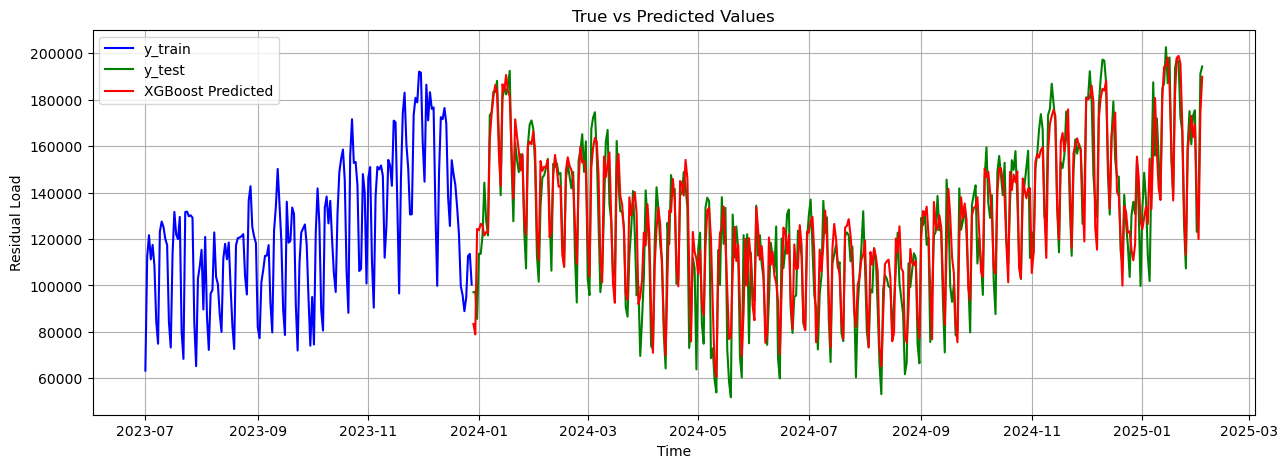

In [23]:
# Plotting prediction results
start_date = '2023-07-01'
end_date = y_test.index[-1]
plot_predictions(y_train, y_test, xgb_pred, start_date, end_date)

### Feature Importance

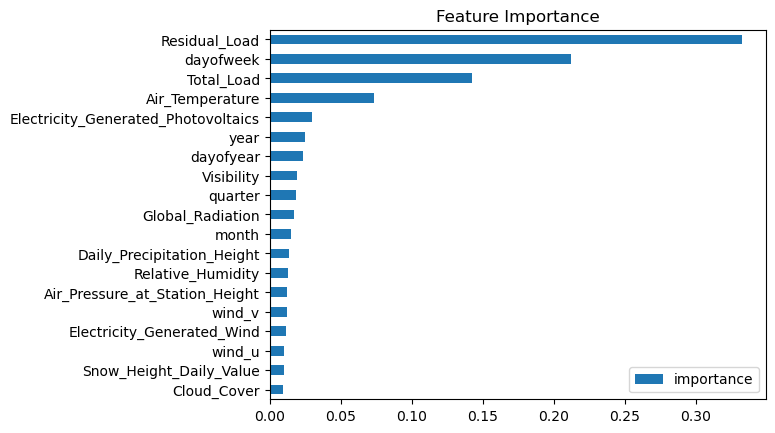

In [24]:
fi = pd.DataFrame(data=xgb_model.feature_importances_, index=xgb_model.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Different Approach

## Forecasting Energy Consumption (Total Grid Load)

--- XGBoost Cross-Validation Results ---
Avg MAE: 7743.08 (in MWh)
Avg RMSE: 10893.28 (in MWh)
Avg R² Score: 0.81
Avg MAPE: 5.10 %


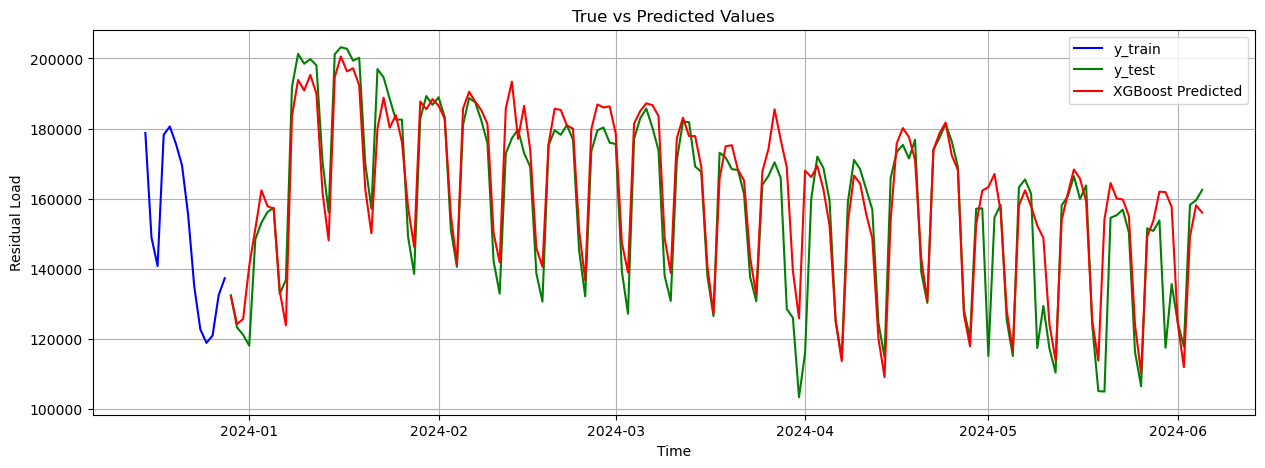

In [25]:
"""
### Relevant Features for Energy Consumption:
These features impact how much energy is used by households, businesses, and industries:
- Total_Load
- Air_Temperature → (Heating & cooling demand increase with extreme temperatures.)
- Relative_Humidity → (Affects air conditioning and heating needs.)
- Air_Pressure_at_Station_Height → (May have a minor effect on weather-driven consumption patterns.)
- Cloud_Cover → (Influences daylight hours, which affects lighting and HVAC usage.)
- holiday → (Holidays often reduce industrial and commercial energy use.)
- Other Temporal Features

"""

selected_features_for_consumption_forecasting = [
    'Total_Load', 
    'Air_Temperature', 'Relative_Humidity', 'Air_Pressure_at_Station_Height', 'Cloud_Cover', # Weather Features
    'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'holiday'  # Temporal features
]

df_consumption = df_transformed[selected_features_for_consumption_forecasting]

Xc = df_consumption.drop(columns=['Total_Load'])
yc = df_consumption['Total_Load']

# Train, validate the model and extract relevant returned values
avg_mae, avg_rmse, avg_r2, avg_mape, y_train, y_test, xgb_pred, xgb_model = train_xgboost_model(Xc, yc)

# Plotting prediction results
start_date = '2023-12-15'
end_date = '2024-06-05'
plot_predictions(y_train, y_test, xgb_pred, start_date, end_date)

## Forecasting Energy Generation (Wind + Photvoltaics)

In [26]:
"""
### Key Features for Wind and PV Energy Generation:
- Global_Radiation: Impacts PV generation directly; more sunlight = more energy.
- wind_u & wind_v: Components of wind velocity; used to calculate wind speed, critical for wind energy generation.
- ==Air_Temperature: Affects both wind turbines and PV efficiency; ideal in moderate temperature ranges.
- ==Relative_Humidity: Influences PV efficiency and wind turbine performance.
- Cloud_Cover: Reduces sunlight for PV generation.
- ==Visibility: Correlates with cloud cover and fog, which can reduce solar radiation and wind turbine performance.
- Daily_Precipitation_Height & Snow_Height_Daily_Value: Rain and snow can hinder both PV and wind turbine performance.

### Temporal Features:
- dayofweek, quarter, month, year, dayofyear, holiday: Impact energy generation patterns due to weather and demand variations over time.

"""

selected_features_for_generation_forecasting = [
    'electricity_generated',
    
    'Global_Radiation','wind_u', 'wind_v','Air_Temperature', 
    'Relative_Humidity', 'Cloud_Cover', 'Visibility', 
    'Daily_Precipitation_Height', 'Snow_Height_Daily_Value', # Weather Features
    
    'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'holiday'  # Temporal features,
]

df_generation = df_transformed[selected_features_for_generation_forecasting]

Xg = df_generation.drop(columns=['electricity_generated'])
yg = df_generation['electricity_generated']

# Train, validate the model and extract relevant returned values
avg_mae, avg_rmse, avg_r2, avg_mape, y_train, y_test, xgb_pred, xgb_model = train_xgboost_model(Xg, yg)

# Plotting prediction results
start_date = '2023-12-15'
end_date = '2024-06-05'
plot_predictions(y_train, y_test, xgb_pred, start_date, end_date)

KeyError: "['electricity_generated'] not in index"

### TODO
### Just ignore this
- Timeseries Cross Validation✔️
- Fine Tuning of XGBoost's Parameter and Hyperparameter 
  
  Relevant source: https://www.youtube.com/watch?v=1rZpbvSI26c


- Lag Feature Optimization ✔️
  
  Sources: https://www.youtube.com/watch?v=z3ZnOW-S550


- knn review when there's still time




# Notes
## 1. Reason to use xgboost
XGBoost
Pros:
Often performs well for many types of problems, including time series, because it handles both regression and classification tasks effectively.
Can handle missing data and outliers well.
Strong regularization helps avoid overfitting.
Cons:
XGBoost isn’t inherently designed for time series problems. It doesn’t have a built-in way to handle time dependencies unless you explicitly engineer features like lag variables or rolling windows.
Tuning XGBoost for time series can be tricky and requires expertise.

## 2. Why TimeSeriesSplit works better (Timeseries Cross Validation):
### Avoiding data leakage:

In traditional cross-validation, data from future periods may be used to predict past periods, which is unrealistic and would cause data leakage. TimeSeriesSplit ensures that the model only has access to past data to predict future outcomes (no peeking ahead). This is crucial for time series problems, where future values cannot inform past predictions.

### Training on more data:

With each fold in time series cross-validation, the training set is progressively larger because it includes all data up to the test set for that fold. This means that the model is exposed to a growing amount of data, which typically improves its ability to generalize, especially for time series models.
By the end of the cross-validation process, the model has been trained on almost all of the data and evaluated multiple times, which leads to a more stable and reliable performance estimate.
### Realistic performance estimation:

TimeSeriesSplit gives a more accurate estimation of how the model will perform in production, where the data always arrives sequentially. The performance is measured on data that is strictly "in the future" relative to the training set, simulating how the model would behave in real-world forecasting.